In [1]:
#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils

import skimage
import napari
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tifffile as tif

import ipywidgets as widgets



### Functions

In [2]:

#loading slices 
def load(dirname, start_slice, slices): 
    flow_data = []

    fname = (os.listdir(dirname))
    for i in range(start_slice, start_slice + slices):
        im = Image.open(os.path.join(dirname, fname[i]))
        imarray = np.array(im)
        flow_data.append(imarray)

    # convert to a 3D array and normalise so data is between 0 and 1 
    flow_data  = np.asarray(flow_data) 
    flow_data = utils.preprocess(flow_data)
    return(flow_data)

#filering function
def nlm_denoise(Img,patch,dist):
    
    def nlm_denoise_wrap(array):
        correct=img_as_float(array[0])
        sigma_est = np.mean(estimate_sigma(correct))
        correct = denoise_nl_means(correct, h=2 * sigma_est, sigma=sigma_est,fast_mode=True,patch_size=patch, patch_distance=dist)
        return correct[np.newaxis, ...]
    
    denoise=skimage.util.apply_parallel(nlm_denoise_wrap,Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)
    
    return  denoise


# segmentation 

def simple_thresholding(img: np.array, min_threshold: float, max_threshold: float) -> np.array:
    return ((img.max() - img.min()) * min_threshold + img.min() <= img) & (img <= (img.max() - img.min()) * max_threshold + img.min())


def phase_segmentation_adapted_watershed(im, grain_thresh, pore_thresh):
    #initial 2D code stolen from Griffin Chure

    """
    Performs watershed segmentation on the greyscale image 
    
    Parameters
    ----------
    im : 3D array
        Image to be segmented. 
    
    grain_thresh: float
        Threshold below which grains exist. 
    pore_thresh: float 
        Threshold above which background exists. 
    
    Output
    -------
    final_seg: segmented image 
    """
    
    # Make sure that the input image is between 0 and 1 
    if np.max(im) != 1.0:
        im = (im - im.min()) / (im.max() - im.min())

    im = im.astype(np.float32)
    #plot histogram with limits of what is pore and what is grain shown
    bins =255
    fig, ax = plt.subplots(figsize =(10, 7))
    hist_values = im.ravel()
    hist_values = hist_values[hist_values < 0.99]
    y, x, _ = plt.hist(hist_values, bins=bins, histtype='step', color='red')

    # Normal distribution to get the max threshold 
    loc         =  np.argmax(y)                             #find peak 
    update_list = hist_values[hist_values > x[loc]]
    update_y, update_x, _ = plt.hist(update_list, bins=bins, histtype='step', color='red')
    loc2                  =  np.argmax(update_y[update_y< (0.0001 * y.max())])

    #pore_thresh = (x[loc] - (update_x[loc2] - x[loc])) *1.1
    plt.axvline(grain_thresh, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(pore_thresh, color='k', linestyle='dashed', linewidth=1)
    plt.show()

    # Generate the catchment basins for watershed
    print('Making the catchment basin')
    basins = np.zeros_like(im)
    basins[im < grain_thresh] = 2
    basins[im > pore_thresh] = 1
    basins = basins.astype(np.float32)

    # Peform the watershed by flooding. 
    print('Flood the basin')
    flood_seg = skimage.segmentation.watershed(im , basins)
    flood_seg = flood_seg > 1.0

    # Compute the distance matrix
    print('Compute the distance matrix')
    distances = ndi.distance_transform_edt(flood_seg)
    
    #Find the maxima NB this is taking a while on 3D images 
    print('Find the maxima')
    local_max = skimage.morphology.local_maxima(distances)
    max_lab = skimage.measure.label(local_max)

    #Perform the topological watershed. 
    print('Perform the topological watershed')
    final_seg = skimage.segmentation.watershed(-distances, max_lab, mask=flood_seg)

    # Remove any stray crap. 
    final_seg = skimage.morphology.remove_small_objects(final_seg, min_size=40)
    final_seg = skimage.morphology.remove_small_holes(final_seg, area_threshold=40)
    
    return np.array(final_seg, dtype=np.uint8)

### Load in the dry scan and filter

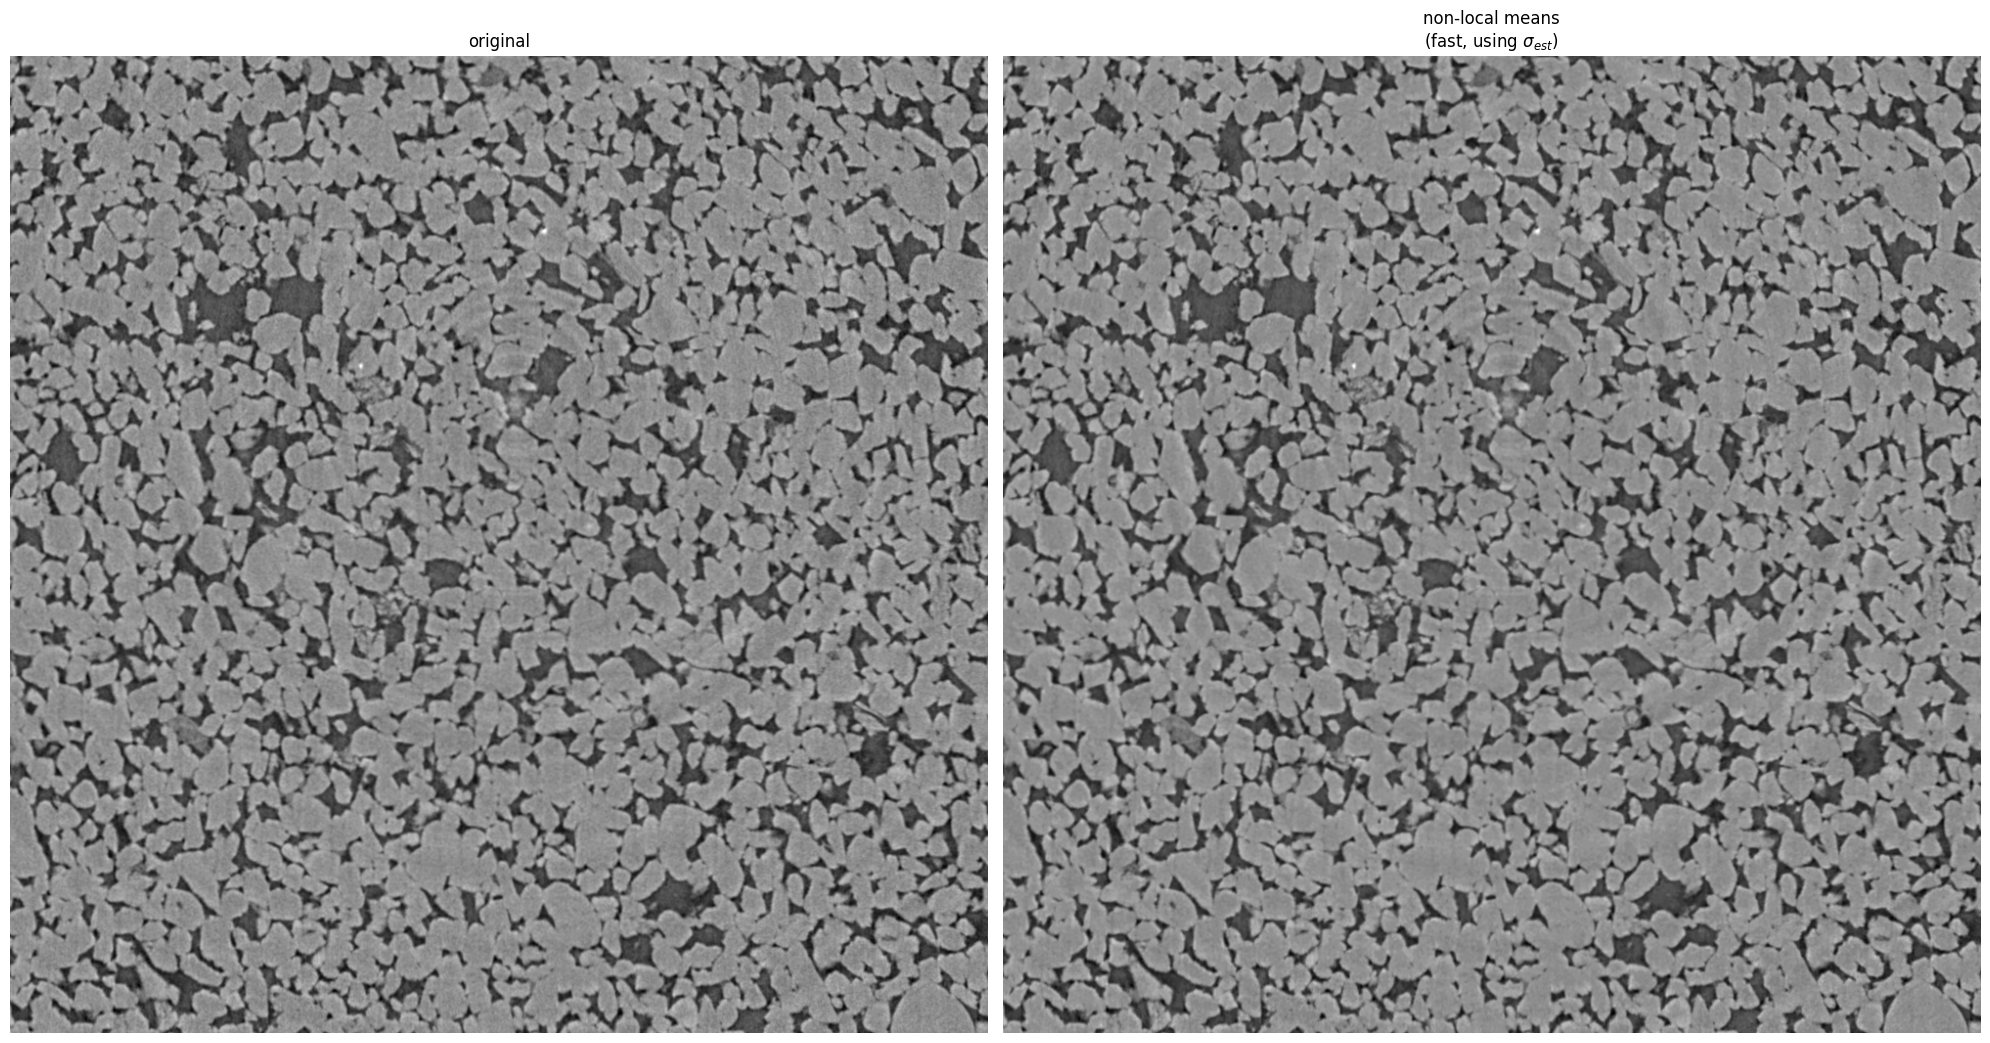

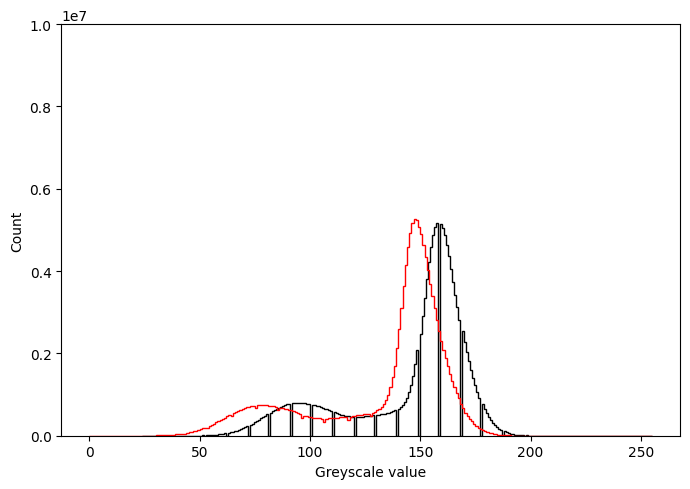

In [3]:
dry_data= load(dirname ='C:\\Users\\cspurin\\Documents\\GitHub\\segmenting-xrays\\cat_dry\\', start_slice=0, slices=500)

denoise_dry = nlm_denoise(dry_data, patch = 3,  dist = 6)


#check the filtering process 
#plot of filtered images (zoomed in for QC)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(dry_data[1, :, :],cmap='gray')
ax[0].axis('off')
ax[0].set_title('original')


ax[1].imshow(denoise_dry[1, :, :],cmap='gray')
ax[1].axis('off')
ax[1].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()
plt.show()

# can check the peak signal-to-noise ratio (PSNR) metric for each case if needed e.g. if you change the filtering parameters 
#psnr2_fast = peak_signal_noise_ratio(dry_crop, utils.preprocess(denoise2_fast))

#plot of the histograms (entire image, not the zoomed in image)
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.set_xlabel('Greyscale value')
ax.set_ylabel('Count')

#ax.set_xlim(0, 0.9) 
ax.set_ylim(0, 10**7) 

ax.hist(dry_data.ravel(), bins=bins, histtype='step', color='black')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

ax.hist(utils.preprocess(denoise_dry).ravel(), bins=bins, histtype='step', color='red')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

fig.tight_layout()
plt.show()
del(dry_data)


### Segmentation in 3D 

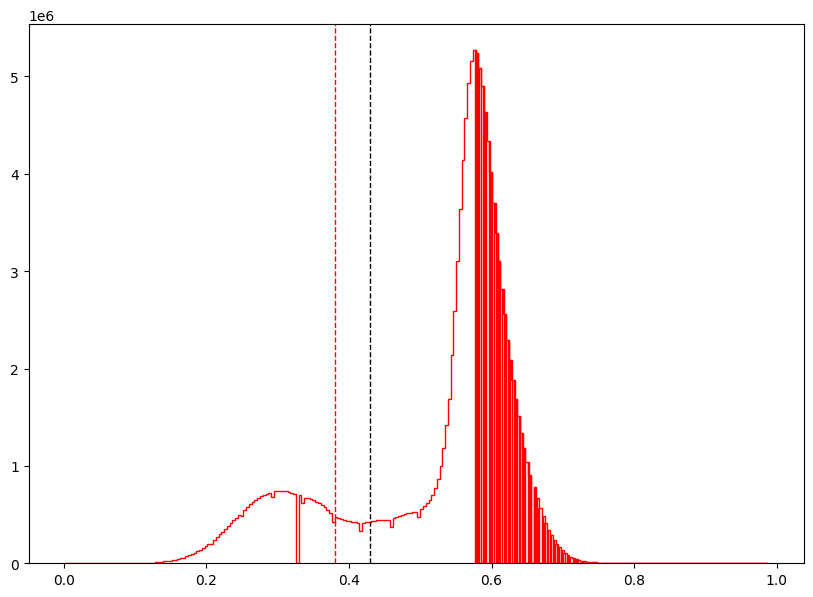

Making the catchment basin
Flood the basin
Compute the distance matrix
Find the maxima
Perform the topological watershed


c:\Users\cspurin\Documents\GitHub\segmenting-xrays\env\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [4]:
#perform the segmentation 
#potential to automate the values based on Gaussian curves for the pore space and grains 
input_segmentation                   = img_as_ubyte(utils.preprocess(denoise_dry.transpose(1,2,0))) #must transpose the image for the input to be xyz, previously zxy
segmented_img   = phase_segmentation_adapted_watershed(input_segmentation, grain_thresh=0.38, pore_thresh = 0.43) 

#NB the histogram is normalised for the segmentation. Currently the mask values are included in this, so if you do a subvolume, then the threshold values need to change. 
#without the mask the values were 0.2 and 0.28 



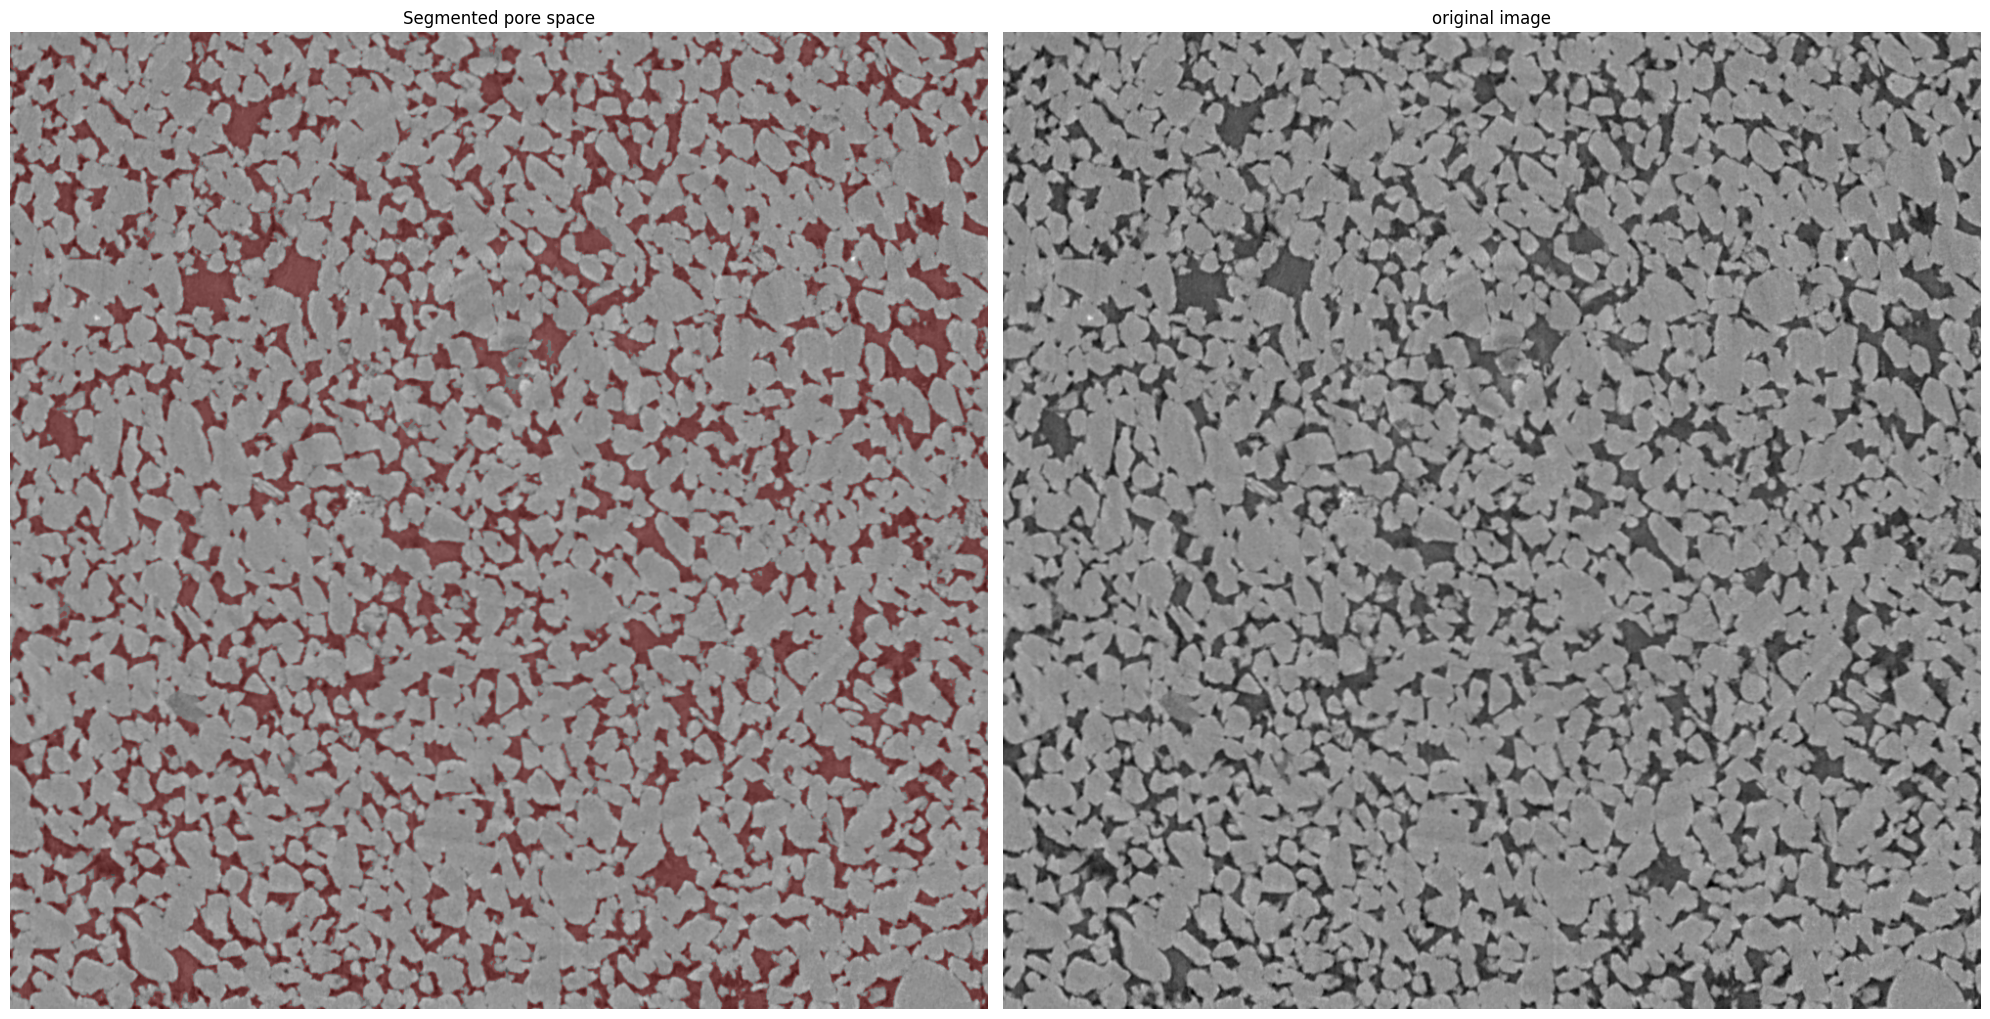

In [5]:
#convert to binary and check the segmentation 
segmented_binary             = np.where(segmented_img>0, 1, segmented_img).astype(np.bool8)
greyscale_input              = (input_segmentation - input_segmentation.min()) / (input_segmentation.max() - input_segmentation.min()) * 255


seg_dry = utils.sanity_check(greyscale_input[:,:,8].astype(np.uint8), segmented_binary[:,:,8], 0.2)



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(seg_dry,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Segmented pore space')


ax[1].imshow(greyscale_input[:,:,8],cmap='gray')
ax[1].axis('off')
ax[1].set_title('original image')

fig.tight_layout()
plt.show()




### Save the image 

In [6]:
segmented_binary_save         = segmented_binary.transpose(2, 0, 1)
tif.imsave('segmented_cat4_5.tif', segmented_binary_save, bigtiff=True)


C:\Users\cspurin\AppData\Local\Temp\ipykernel_9420\2312940597.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tif.imsave('segmented_cat4_5.tif', segmented_binary_save, bigtiff=True)


### Play with the result! 

In [7]:
z_widget = widgets.IntSlider(
    value=2,
    min=0,
    max=10,
    step=1,
)


overlay_widget = widgets.RadioButtons(
    options=[True, False],
    description='Overlay:',
    disabled=False,
)


def view_slice(img: np.ndarray, z: int, overlay: bool, mask: bool) -> None:
    depth, h, w = img.shape
    assert isinstance(img, np.ndarray)
    assert isinstance(z, int)
    assert isinstance(overlay, bool)
    assert 0 <= z < depth

    slice = img[:, :, z]

    if overlay:
        slice = utils.preprocess(slice)
        mask  = mask[:, :, z]
        slice = utils.sanity_check(slice, mask)
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(slice, cmap='gray')
    plt.show()


widgets.interact(view_slice, img=widgets.fixed(greyscale_input[500:1000,500:1000,:]), z=z_widget, overlay=overlay_widget, mask = widgets.fixed(segmented_binary[500:1000,500:1000,:] ))

interactive(children=(IntSlider(value=2, description='z', max=10), RadioButtons(description='Overlay:', option…

<function __main__.view_slice(img: numpy.ndarray, z: int, overlay: bool, mask: bool) -> None>

In [33]:
# Code that reads in the segmented file and then matches the slices and saves as one large one 

#read in the segments 
im_bottom          = skimage.io.imread('segmented_cat1.tif')
im_bottom          = im_bottom.astype(np.uint8) 


im_middle          = skimage.io.imread('segmented_cat2.tif')
im_middle          = im_middle.astype(np.uint8) 


im_top          = skimage.io.imread('segmented_cat3.tif')
im_top          = im_top.astype(np.uint8) 





#find matching slice 
for k in range(0, im_middle.shape[0]): 
    diff = im_middle[k, :, :] - im_bottom[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=50) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged = np.append(im_bottom[:,:,:], im_middle[k+1:, :, :], axis = 0)
        print('Matching slice, merge', k)
        break 

print(merged.shape)




#find matching slice 
for m in range(0, im_top.shape[0]): 
    diff = im_top[m, :, :] - merged[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=50) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged2 = np.append(merged[:,:,:], im_top[m+1:, :, :], axis = 0)
        print('Matching slice, merge', m)
        break 

print(merged2.shape)


Matching slice, merge 8
(439, 1000, 1000)
Matching slice, merge1 7
(680, 1000, 1000)
Matching slice, merge2 98
(730, 1000, 1000)
Matching slice, merge3 48
(930, 1000, 1000)
Matching slice, merge4 28
(1001, 1000, 1000)


In [34]:

tif.imwrite('merged_segmented_Cat.tif', merged4[:1000,:,:], bigtiff=True)